In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [2]:
df = pd.read_csv('titanic.csv')
target = df.survived
df = df.drop(['survived', 'alive'], axis=1)
df = df.replace(r'\s+', np.nan, regex=True)
df = pd.get_dummies(df)
df = df.fillna(df.mean())

In [3]:
cm = df.corr()

In [4]:
li = hierarchy.linkage(distance.squareform(1-np.abs(cm)))

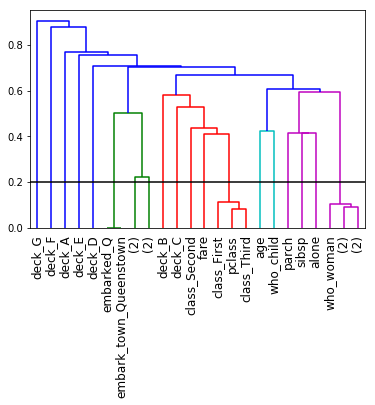

In [5]:
hierarchy.dendrogram(
    li,
    truncate_mode='lastp',
    p=24,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    labels=cm.columns,
    count_sort=True,
    color_threshold=.6
)
plt.axhline(y=.2, c='k')
None

In [6]:
clust = hierarchy.fcluster(li, t=.3, criterion='distance')
f_clusters = pd.Series(clust, index=cm.columns).sort_values()
f_clusters

embark_town_Queenstown      1
embarked_Q                  1
embark_town_Southampton     2
embark_town_Cherbourg       2
embarked_S                  2
embarked_C                  2
class_Third                 3
class_First                 3
pclass                      3
fare                        4
class_Second                5
deck_C                      6
deck_B                      7
age                         8
who_child                   9
sex_male                   10
who_woman                  10
sex_female                 10
adult_male                 10
who_man                    10
sibsp                      11
alone                      12
parch                      13
deck_D                     14
deck_E                     15
deck_A                     16
deck_F                     17
deck_G                     18
dtype: int32

In [7]:
cl = RandomForestClassifier(n_estimators=300, max_depth=4, max_features=.5, random_state=2)
cl.fit(df, target)
f_weights = pd.Series(cl.feature_importances_, index=df.columns)

In [8]:
not_clustered = f_weights.index[~f_weights.index.isin(f_clusters.index)]
nc_cluster_names = ['nc' + str(n) for n in range(len(not_clustered))]
not_clustered_clusters = pd.Series(nc_cluster_names, index=not_clustered, name='cluster')
f_clusters_full = f_clusters.astype(str).append(not_clustered_clusters)

fic = pd.DataFrame({'cluster': f_clusters_full, 'weight': f_weights})
cluster_means = fic.groupby('cluster')['weight'].mean().rename('mean_weight')
ficm = fic.join(
    cluster_means, on='cluster'
).sort_values(['mean_weight', 'cluster'], ascending=False)
ficm = ficm.reset_index().set_index(['cluster', 'index'])
ficm

weight  mean_weight
cluster index                                         
10      adult_male               0.212415     0.118838
        sex_female               0.090387     0.118838
        sex_male                 0.102830     0.118838
        who_man                  0.173763     0.118838
        who_woman                0.014795     0.118838
4       fare                     0.087572     0.087572
3       class_First              0.021415     0.063392
        class_Third              0.073445     0.063392
        pclass                   0.095315     0.063392
8       age                      0.045172     0.045172
11      sibsp                    0.029520     0.029520
15      deck_E                   0.008778     0.008778
13      parch                    0.006745     0.006745
5       class_Second             0.006311     0.006311
2       embark_town_Cherbourg    0.003080     0.004211
        embark_town_Southampton  0.005314     0.004211
        embarked_C               0.002426     0.004211
        embarked_S               0.006024     0.004211
14      deck_D                   0.003622     0.003622
9       who_child                0.002531     0.002531
6       deck_C                   0.001764     0.001764
12      alone                    0.001595     0.001595
1       embark_town_Queenstown   0.001891     0.001469
        embarked_Q               0.001046     0.001469
16      deck_A                   0.001228     0.001228
7       deck_B                   0.000785     0.000785
17      deck_F                   0.000132     0.000132
18      deck_G                   0.000098     0.000098

In [9]:
wfct = ficm.reset_index().set_index('index')
top_features = wfct.loc[
    wfct.groupby('cluster').weight.idxmax()
].sort_values('weight', ascending=False)
top_features.weight

index
adult_male                0.212415
pclass                    0.095315
fare                      0.087572
age                       0.045172
sibsp                     0.029520
deck_E                    0.008778
parch                     0.006745
class_Second              0.006311
embarked_S                0.006024
deck_D                    0.003622
who_child                 0.002531
embark_town_Queenstown    0.001891
deck_C                    0.001764
alone                     0.001595
deck_A                    0.001228
deck_B                    0.000785
deck_F                    0.000132
deck_G                    0.000098
Name: weight, dtype: float64

In [15]:
cl = RandomForestClassifier(n_estimators=300, max_depth=4, max_features=.5, random_state=2)
np.mean(cross_val_score(cl, df, target, cv=3))

0.8237934904601572

In [16]:
cl = RandomForestClassifier(n_estimators=300, max_depth=4, max_features=.5, random_state=2)
np.mean(cross_val_score(cl, df[top_features.index], target, cv=3))

0.819304152637486